# Data Ted
## Analisi dei Ted Talk
---
#### Matano Francesco S5253162
#### Vassallo Edoardo S4965918 
---

# Introduzione ed Obiettivi
Il nostro obbiettivo è analizzare l'evoluzione nel tempo dei dati in nostro possesso, relativi ai video pubblicati sulla piattaforma Ted-Ed. <br> Secondariamente, intendiamo studiare le eventuali differenze fra sottogruppi della popolazione, ottenuti tramite operazioni di quantizzazione e tagging

# 0. Preparativi
> ## Librerie importate


In [62]:
##LIB FOR UTIL THING
import os
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.metrics as metrics 
import re
##LIB FOR ML THING
import pandas as pd 
import scipy.stats as stats
import datetime as dt
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

> ## Funzioni utilizzate per il notebook

In [63]:
def print_stats_field(df, field):
    print("--------------------------------------------"   )
    print("Statistiche relative a:  ", field               )
    print("--------------------------------------------"   )
    print("Media:                   ",  df[field].mean()   )
    print("Moda:                    ",  df[field].mode()[0])
    print("Mediana:                 ",  df[field].median() )
    print("Varianza:                ",  df[field].var()    )
    print("Deviazione standard:     ",  df[field].std()    ) 
    print("--------------------------------------------"   )

In [64]:
def print_all_olap_on_first_dim(olap_df, xlabel, ylabel, list_of_labels):

    cols = (len(list_of_labels) // 5) + 1

    plt.figure(figsize=(20, 30))

    for element in range(0, len(list_of_labels)):
        plt.subplot(cols, 5, element+1)
        plt.title(list_of_labels[element])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.imshow(olap_df[element, :, :])
        plt.colorbar()

        for (j,i),label in np.ndenumerate(olap_df[element, :, :]):
            plt.text(i,j,"{:.0f}".format(label),ha='center',va='center')

    plt.show()

In [65]:
def print_ttest_1samp(first_dataset, second_dataset, column, name):
    t, p_value = stats.ttest_1samp(a = first_dataset[column].values, popmean= second_dataset[column].mean())
    print("\nt-test on ", name, ":")
    print('Valore test: ', t)
    print('P-value: ', p_value)

In [66]:
def print_chi_squared(obs, exp, name):
    chi_squared, p_value = stats.chisquare(f_obs= obs, f_exp = exp)
    print("\nt-test on ", name, ":")
    print('Chi-quadrato: ', chi_squared)
    print('P-value: ', p_value)

In [67]:
def cluster_df(df, x_label, y_label, z_label, n_cluster):
     scaler = preprocessing.MinMaxScaler()
     tmp = df[[x_label, y_label, z_label]]
     scaler.fit(tmp)
     scaled = scaler.fit_transform(tmp)
     scaled_df = pd.DataFrame(scaled, columns=tmp.columns)
     kmeans = KMeans(n_clusters= n_cluster, random_state=0, n_init='auto')
     kmeans.fit(scaled_df)
     fig = plt.figure()

     ax = plt.axes(projection ='3d')
     ax.set_xlabel(x_label)
     ax.set_ylabel(y_label)
     ax.set_zlabel(z_label)
     ax.scatter(scaled_df[x_label].values, scaled_df[y_label].values, scaled_df[z_label].values, c = kmeans.labels_, alpha=0.5)
     # create_3d_plot_gif(ax, fig)
     return silhouette_score(scaled_df, kmeans.labels_)


In [68]:
def create_3d_plot(xy_struct, z_struct, x_label, y_label, lin_reg, plt):
    ###Create x, y surface meshgrid
    x_surf, y_surf = np.meshgrid(
                                  np.linspace(xy_struct[x_label].min(), xy_struct[x_label].max(), 100),
                                  np.linspace(xy_struct[y_label].min(), xy_struct[y_label].max(), 100)
                                )

    onlyX = pd.DataFrame({x_label : x_surf.ravel(), y_label: y_surf.ravel()})
    fittedY = np.array(lin_reg.predict(onlyX))
    z_pred = lin_reg.predict(xy_struct)

    print('Score:', lin_reg.score(xy_valid, z_valid))
    
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color='green', alpha=0.3)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_struct, color='red', alpha=0.7)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_pred)
    ax.set_title('Piano di predizione e dati di training')
    # create_3d_plot_gif(ax, fig)
    plt.show()
    return z_pred


In [69]:
def create_3d_plot_gif(ax, fig):
    # DA INSTALLARE PER LA GENERAZIONE DELLE GIF
    import imageio.v2 as imageio # pip install imageio
    from natsort import natsorted # pip install natsort

    png_dir = 'gif_production/resources'
    images = []

    # generiamo i frame
    for ii in np.arange(0, 360, 1):
          ax.view_init(elev=32, azim=ii)
          fig.savefig('gif_production/resources/frame_%d.png' % ii)

    # generiamo la gif
    for file_name in natsorted(os.listdir(png_dir)):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

    # Make it pause at the end so that the viewers can ponder
    for _ in range(10):
        images.append(imageio.imread(file_path))

    imageio.mimsave('gif_production/gif/movie.gif', images, fps=120)


> ##  Definizione di array globali utilizzati all'interno del notebook
 N.B. <u> Nella quantizzazione relativa agli anni, si è deciso di catalogare tutti gli anni precedenti al 2000 in un unico gruppo, sulla base dei componenti della popolazione </u>

In [70]:
#quantizzazione dell views
quantize_views = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '1M-20M', '>20M'  ]
#quantizzazione dei likes
quantize_likes = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '>1M'             ]

---

> ## Import Dataset

In [71]:
daTed = pd.read_csv("data_ted.csv")
daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


# 1. Pulizia Dati

Analizzando i nostri dati, abbiamo ritrovato i seguenti errori:

1. È presente una riga con autore mancante

In [72]:
print(daTed.loc[(daTed['author'].isnull())])

                   title author           date  views  likes  \
3039  Year In Ideas 2015    NaN  December 2015    532     15   

                                          link  
3039  https://ted.com/talks/year_in_ideas_2015  


2. Due delle righe presenti vengono erroneamente datati al gennaio 1970, data sospetta in quanto valore minimo dei timestamp UNIX.<br> L'errore è stato verificato cercando i video in questione online.

In [73]:
print(daTed.loc[(daTed['date'] == 'January 1970')])

                                 title          author          date   views  \
736               Innovations in sleep      Beautyrest  January 1970   60000   
738  Love letters to what we hold dear  Debbie Millman  January 1970  192000   

     likes                                               link  
736   1800  https://ted.com/talks/beautyrest_innovations_i...  
738   5700  https://ted.com/talks/debbie_millman_love_lett...  


Siccome questi errori riguardano solo un paio di righe, si è deciso di correggere le righe, invece che eliminarle, nel seguente modo:

1. Vedendo [il video in questione](https://www.ted.com/talks/year_in_ideas_2015) si è visto che si tratta di un video celebrativo realizzato dall'azienda stessa. Si è deciso quindi di attribuirlo all'autore *"TED"*.

In [74]:
daTed.loc[(daTed['author'].isnull()), 'author'] = 'TED'
print(daTed.loc[(daTed['author'].isnull())])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


2. Similmente, possiamo rintracciare la data di pubblicazione dei video online *"Innovations in sleep"* è stato [caricato](https://youtu.be/mo264ECPacQ?si=O2mQA_2kww7flGm3) sulla pagina Youtube di TED nel Luglio 2020.<br>  *"Love letters to what we hold dear"* è stato presentato nel corso di TED2020.<br> Cercando la [scaletta](https://tedlive.ted.com/webcasts/t2020/session/419) dell'evento, scopriamo che è stato presentato nel Giugno di quell'anno.

In [75]:
daTed.loc[(daTed['title'] == 'Innovations in sleep'),              'date'] = 'July 2020'
daTed.loc[(daTed['title'] == 'Love letters to what we hold dear'), 'date'] = 'June 2020'

print(daTed.loc[(daTed['date'] == 'January 1970')])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


L'ultima correzione necessaria è al **formato delle date**. <br>
Al momento la data di pubblicazione è memorizzata come una stringa mese-anno. <br>Decidiamo di tradurla nel tipo *datetime*, per aiutare in seguito.

In [76]:
daTed["date"] = pd.to_datetime(daTed['date'], format='%B %Y')

# 2. Visualizzazione dei dati

La nostra analisi si basa principalmente sullo studio dell'evoluzione temporale dei dati.<br> Cominciamo quindi mostrando un grafico del numero di uscite rispetto all'anno.

<Axes: title={'center': 'Numero di Video per Anno'}, xlabel='Anno', ylabel='N° Video'>

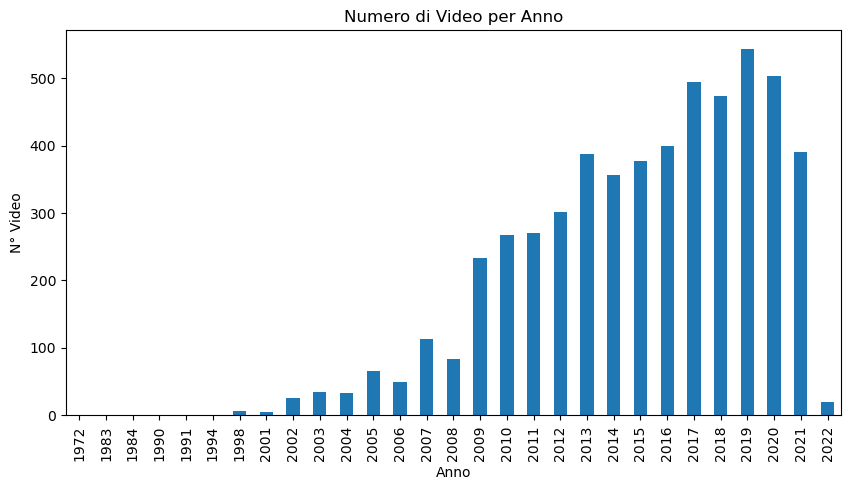

In [77]:
daTed.groupby(daTed.date.dt.year)['title'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Anno", 
                                                         title   = "Numero di Video per Anno" )

Da questo video possiamo notare la crescita negli anni del numero di video, in particolare in seguito al 2009. Inoltre, la maggior parte dei video è uscita nel decennio 2019-2019

Vediamo ora di studiare la **qualità** di questi video, sulla base dei valori di like e visualizzazioni. Realizziamo a tal scopo, un **OLAP** ad hoc, **quantizzando** le colonne dei likes, views, e data di pubblicazione.

In [78]:
# Quantizzazione per anno
## p.s. min year: 1972
##      max year: 2022

daTed["date_year"] = daTed["date"].dt.year
quantize_years = sorted(daTed["date_year"].unique())

# Quantizzazione per quantità di views
## p.s. max views: 72M

daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
daTed.loc[daTed['views'].between(10000    , 99999   , 'both'), 'views_quant'] = quantize_views[1]
daTed.loc[daTed['views'].between(100000   , 499999  , 'both'), 'views_quant'] = quantize_views[2]
daTed.loc[daTed['views'].between(500000   , 999999  , 'both'), 'views_quant'] = quantize_views[3]
daTed.loc[daTed['views'].between(1000000  , 19999999, 'both'), 'views_quant'] = quantize_views[4]
daTed.loc[daTed['views'].between(20000000 , 80000000, 'both'), 'views_quant'] = quantize_views[5]

# Quantizzazione per quantità di likes
## p.s. max likes: 2.1M

daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]
daTed.loc[daTed['likes'].between(10000   , 99999   , 'both'), 'likes_quant'] = quantize_likes[1]
daTed.loc[daTed['likes'].between(100000  , 499999  , 'both'), 'likes_quant'] = quantize_likes[2]
daTed.loc[daTed['likes'].between(500000  , 999999  , 'both'), 'likes_quant'] = quantize_likes[3]
daTed.loc[daTed['likes'].between(1000000 , 10000000, 'both'), 'likes_quant'] = quantize_likes[4]

daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        5440 non-null   object        
 1   author       5440 non-null   object        
 2   date         5440 non-null   datetime64[ns]
 3   views        5440 non-null   int64         
 4   likes        5440 non-null   int64         
 5   link         5440 non-null   object        
 6   date_year    5440 non-null   int32         
 7   views_quant  5440 non-null   object        
 8   likes_quant  5440 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(5)
memory usage: 361.4+ KB


/tmp/ipykernel_8997/653107323.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
/tmp/ipykernel_8997/653107323.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]


,title,author,date,views,likes,link,date_year,views_quant,likes_quant
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,2021-12-01,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...,2021,100K-500K,10K-100K
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,2022-02-01,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...,2022,100K-500K,<10K
2,How play can spark new ideas for your business,Martin Reeves,2021-09-01,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...,2021,100K-500K,10K-100K
3,Why is China appointing judges to combat clima...,James K. Thornton,2021-10-01,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...,2021,100K-500K,10K-100K
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2021-10-01,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...,2021,<10K,<10K


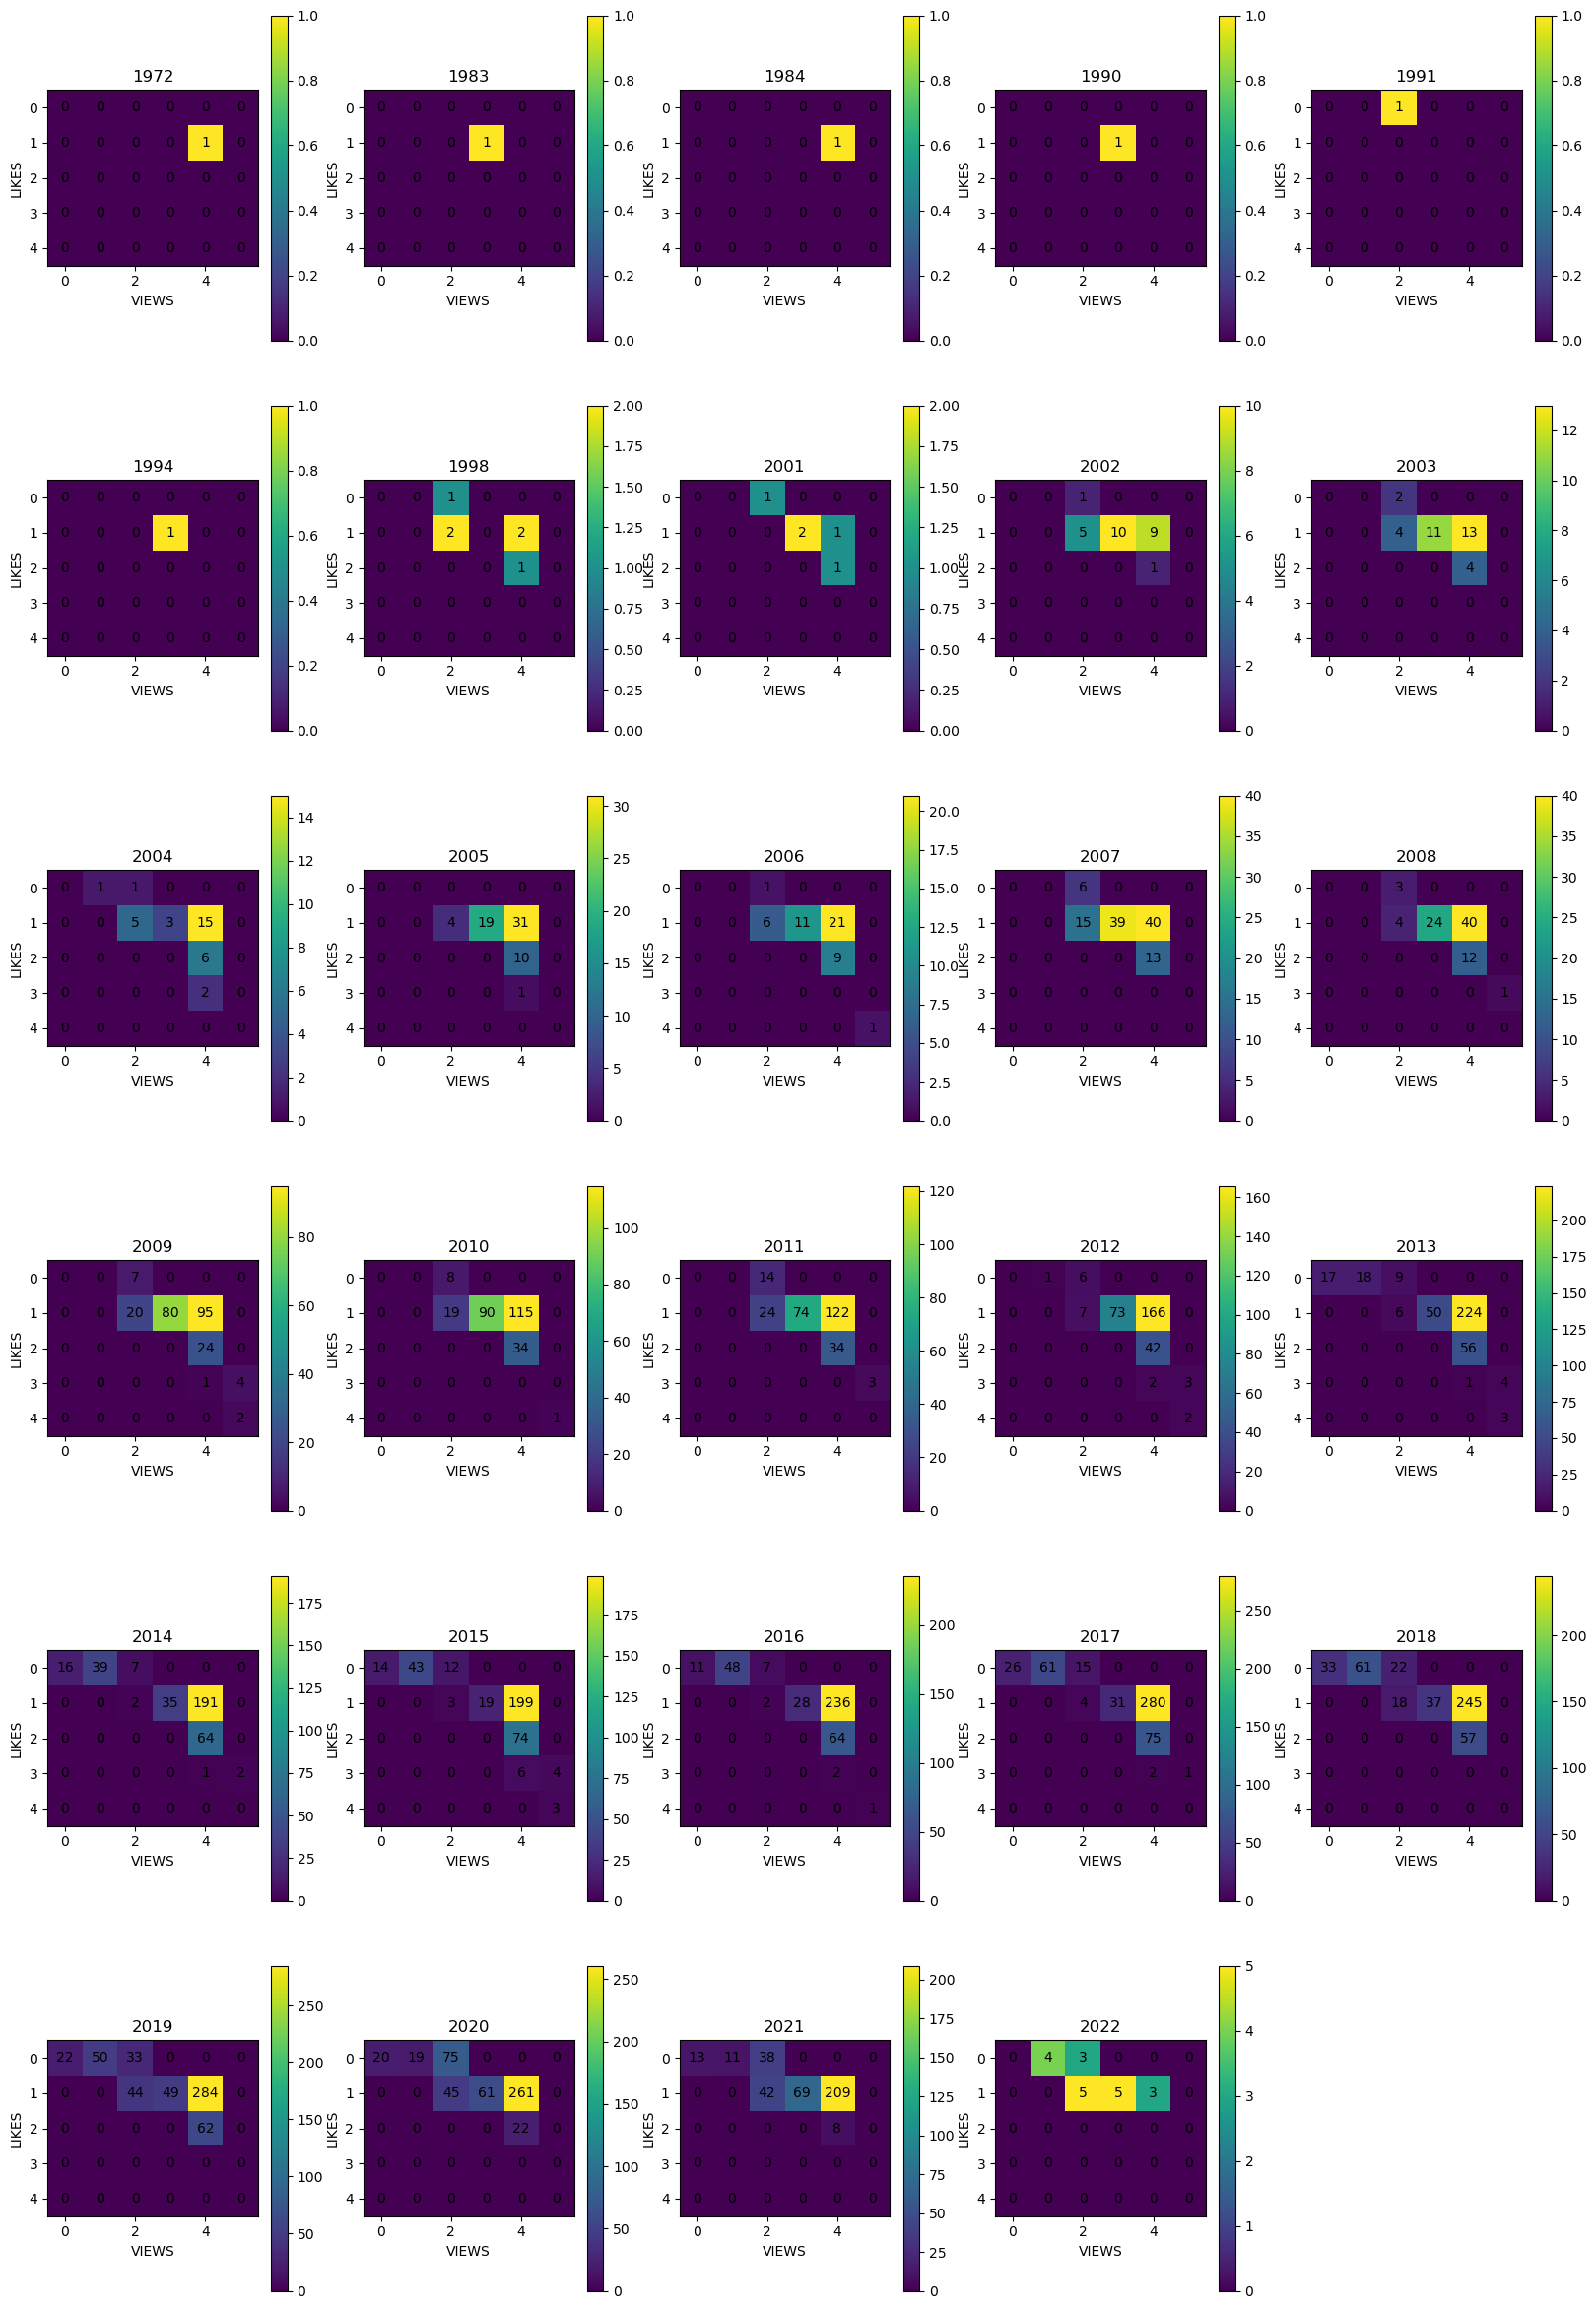

In [79]:
##OLAP che ha come dimensioni: x: le date quantizzate, y: le views quantizzate e z: il numero di like quantizzati
OLAP  = np.zeros((len(quantize_years), len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    views_class = daTed[daTed['views_quant'] == quantize_views[z]]
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            OLAP[x,y,z] = np.sum(
                                (views_class['likes_quant'] == quantize_likes[y]) & 
                                (views_class['date_year']  == quantize_years[x] ) )

print_all_olap_on_first_dim(OLAP, "VIEWS", "LIKES", quantize_years)

Dalla visualizzazione OLAP notiamo che, nonostante la quantità dei video vari notevolmente fra anno ed anno, il rapporto fra views e likes rimane quasi sempre costante (la maggior parte dei video sembra possedere 1M-20M visualizzazioni e 10K-100K like). <br>
Questo può quindi implicare un rapporto fra le due
<br>
<br>
I dati stampati di seguito corrispondono con la visualizzazione 

In [80]:
print_stats_field(daTed, "date_year")
print_stats_field(daTed, 'views')
print_stats_field(daTed, 'likes') 

--------------------------------------------
Statistiche relative a:   date_year
--------------------------------------------
Media:                    2015.0152573529413
Moda:                     2019
Mediana:                  2016.0
Varianza:                 20.27022129797865
Deviazione standard:      4.502246250259825
--------------------------------------------
--------------------------------------------
Statistiche relative a:   views
--------------------------------------------
Media:                    2061575.9579044117
Moda:                     1300000
Mediana:                  1300000.0
Varianza:                 12724186465893.252
Deviazione standard:      3567097.765115676
--------------------------------------------
--------------------------------------------
Statistiche relative a:   likes
--------------------------------------------
Media:                    62607.616727941175
Moda:                     39000
Mediana:                  40500.0
Varianza:                 11

Per studiare la correlazione intuita, stampiamo il grafico relativo al rapporto fra views e likes

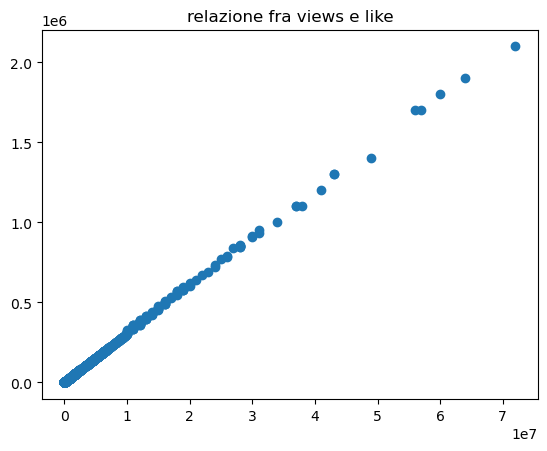

In [81]:
plt.title("relazione fra views e like")
plt.scatter(daTed["views"], daTed["likes"])

Il grafico ci mostra ancora più evidenza di questo rapporto. <br>
Calcolando covarianza e correlazione, la loro relazione appare ancora più ovvia

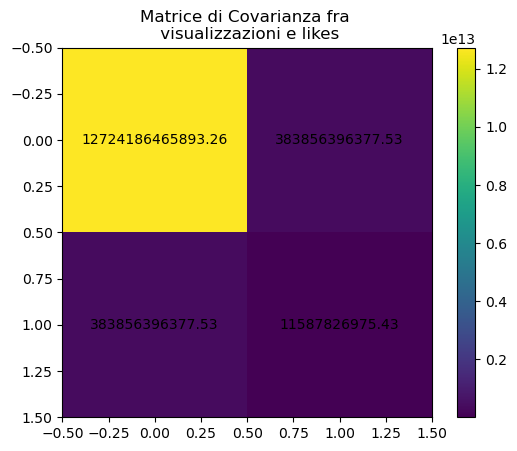

In [82]:
# matrice di covarianza

cov_matrix = daTed[["views", "likes"]].cov()
plt.imshow(cov_matrix)
plt.title("Matrice di Covarianza fra \n visualizzazioni e likes")
plt.colorbar()
for (j,i),label in np.ndenumerate(cov_matrix):
    plt.text(i,j,"{:.2f}".format(label),ha='center',va='center')

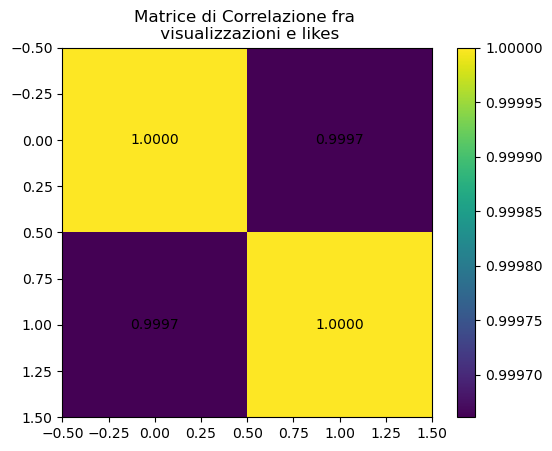

In [83]:
# matrice di correlazione

corr_matrix = daTed[["views", "likes",]].corr()
plt.title("Matrice di Correlazione fra \n visualizzazioni e likes")
plt.imshow(corr_matrix)
plt.colorbar()

for (j,i),label in np.ndenumerate(corr_matrix):
    plt.text(i,j,"{:.4f}".format(label),ha='center',va='center')

# 3. Test Statistici

## T-TEST

#####  Ipotesi: ipotizziamo che la media delle views ottenute nei vari bienni sia simile alla media totale delle view dei dati presenti nel dataset (e che quindi non possa esistere un ipotesi alternativa). </u>

<Axes: title={'center': 'views'}, xlabel='date_year'>

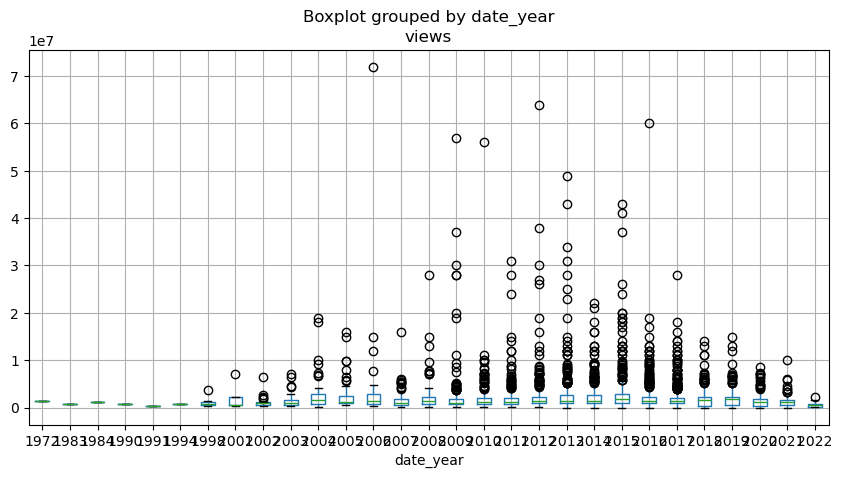

In [84]:
daTed.boxplot(column = "views", by = "date_year", figsize=(10, 5))

Come si può notare dai boxplot qui sopra sono presenti molti outliers nelle decadi: 00's, 10's e 20's.
Considerando che queste sono le decadi con il maggior numero di dati ci aspettiamo anche una varianza complessiva motlo  alta.

In [85]:
popolazione = len(daTed)

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["date_year"] == quantize_years[x]], daTed, "views", quantize_years[x])



t-test on  2003 :
Valore test:  -1.6220743309082197
P-value:  0.11430419047759649

t-test on  2004 :
Valore test:  1.6483243246368204
P-value:  0.10907151218856788

t-test on  2005 :
Valore test:  0.9244821610187695
P-value:  0.3587080119761623

t-test on  2006 :
Valore test:  1.1058932244066195
P-value:  0.27428484729210995

t-test on  2007 :
Valore test:  -2.765894607095807
P-value:  0.00664154617990903

t-test on  2008 :
Valore test:  0.9855743843117651
P-value:  0.32720638363810606

t-test on  2009 :
Valore test:  0.8896853708003017
P-value:  0.37455645574427776

t-test on  2010 :
Valore test:  -0.35970547331330066
P-value:  0.7193528058847316

t-test on  2011 :
Valore test:  0.29977056959568793
P-value:  0.7645828122513227

t-test on  2012 :
Valore test:  1.9468762427830237
P-value:  0.052479531668387265

t-test on  2013 :
Valore test:  2.6748226813474663
P-value:  0.0077940104199484056

t-test on  2014 :
Valore test:  1.568125068405824
P-value:  0.11774033494700097

t-test on  2

Come si può notare dai risultati ottenuti dai ttest svolti, si può vedere come, a meno del caso dei TED degli anni 2002-2004, non possiamo rifiutare il caso della ipotesi nulla (in quanto negli altri casi in cui è possibile fare il ttest ci vengono fuori dei p-value che sono maggiori del nostro livello di significatività che è di 0.05).<br>

####  Risultato: non possiamo dire che esiste una ipotesi alternativa a quella nulla.
Si può vedere dalla stampa della varie medie dei dati qui seguente

In [86]:
print("Media di tutto il dataset", daTed['views'].mean())

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
        print("Media anno", quantize_years[x], ": ", daTed.loc[daTed["date_year"] == quantize_years[x]]['views'].mean())


Media di tutto il dataset 2061575.9579044117
Media anno 2003 :  1599823.5294117648
Media anno 2004 :  3405393.9393939395
Media anno 2005 :  2422738.446153846
Media anno 2006 :  3696122.4285714286
Media anno 2007 :  1563283.185840708
Media anno 2008 :  2476285.7023809524
Media anno 2009 :  2393283.261802575
Media anno 2010 :  1978074.9026217228
Media anno 2011 :  2124273.05904059
Media anno 2012 :  2659556.2913907287
Media anno 2013 :  2738498.7036082475
Media anno 2014 :  2309950.411764706
Media anno 2015 :  3062971.167108753
Media anno 2016 :  2328057.3834586465
Media anno 2017 :  2017962.8282828282
Media anno 2018 :  1716400.8393234673
Media anno 2020 :  1264803.578528827
Media anno 2021 :  1101868.4615384615


## TEST CHI-QUADRO

#### ipotesi: ipotizziamo che dati i grafici visti prima, esista una corrispondenza tra numero di views e likes in un ted talks.

In [87]:
chi_square = np.zeros((len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            chi_square[y,z] += OLAP[x, y, z]
res =  stats.chi2_contingency(chi_square)
# TIP : Provare a fare il confronto fra vaolore ottenuto dal test
# e tabella del chi quadro
print("Risultato della nostra contigency test: ", res.pvalue)

Risultato della nostra contigency test:  0.0


#### Il risultato ottenuto dal nostro test del chi-quadro conferma ciò

# 4. Modello predittivo

### Proviamo a fare modello predittivo anno-count

In [88]:
# generate column "count" with count for year
daTed['count_date'] = daTed.groupby(['date'])['title'].transform('count')
daTed['count_year'] = daTed.groupby(['date_year'])['title'].transform('count')
# per dopo
for x in quantize_years: 
    daTed.loc[daTed['date_year'] == x, 'mean_views_year'] = daTed.loc[daTed['date_year'] == x]["views"].mean()
daTed.head()

,title,author,date,views,likes,link,date_year,views_quant,likes_quant,count_date,count_year,mean_views_year
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,2021-12-01,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...,2021,100K-500K,10K-100K,31,390,1.101868e+06
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,2022-02-01,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...,2022,100K-500K,<10K,8,20,5.735000e+05
2,How play can spark new ideas for your business,Martin Reeves,2021-09-01,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...,2021,100K-500K,10K-100K,27,390,1.101868e+06
3,Why is China appointing judges to combat clima...,James K. Thornton,2021-10-01,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...,2021,100K-500K,10K-100K,72,390,1.101868e+06
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2021-10-01,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...,2021,<10K,<10K,72,390,1.101868e+06


Score: 0.7297070457520467


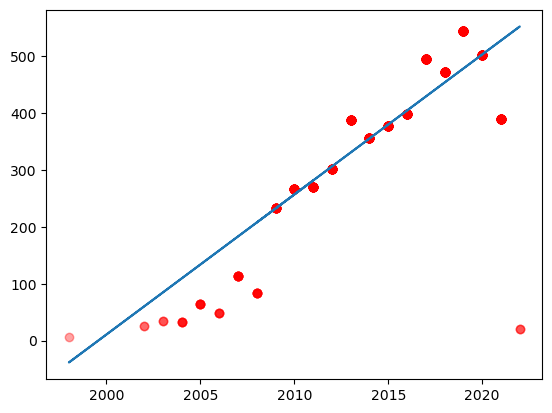

In [92]:
x = daTed[["date_year"]].values.astype(float)
y = daTed["count_year"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)

regressor = LinearRegression()

lin_reg = regressor.fit(x_train, y_train) # alleno sui dati di training

print('Score:', lin_reg.score(x_valid, y_valid))

y_hat = lin_reg.predict(x_valid)
plt.plot(x_valid,y_hat) # retta di predizione
plt.scatter(x_valid,y_valid,c='r',alpha=0.2) # valori reali dei dati di validazione
plt.show()

Score: 0.03010272300742467


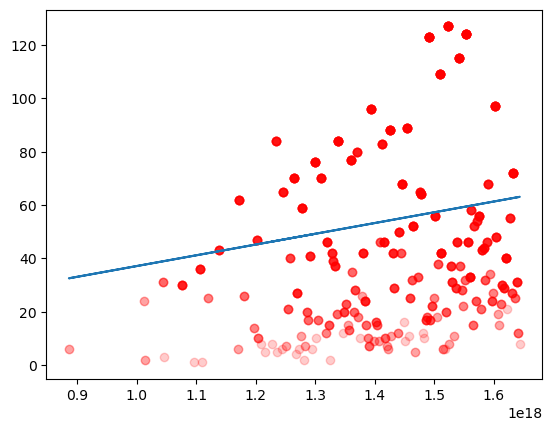

In [97]:
x = daTed[["date"]].values.astype(float)
y = daTed["count_date"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)

regressor = LinearRegression()

lin_reg = regressor.fit(x_train, y_train) # alleno sui dati di training

print('Score:', lin_reg.score(x_valid, y_valid))

y_hat = lin_reg.predict(x_valid)
plt.plot(x_valid,y_hat) # retta di predizione
plt.scatter(x_valid,y_valid,c='r',alpha=0.2) # valori reali dei dati di validazione
plt.show()

### Proviamo a predire data una data il numero di views e like di un video.

/tmp/ipykernel_8997/713888064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy["date"] = xy["date"].values.astype(float)


Score: 0.9992605601358914


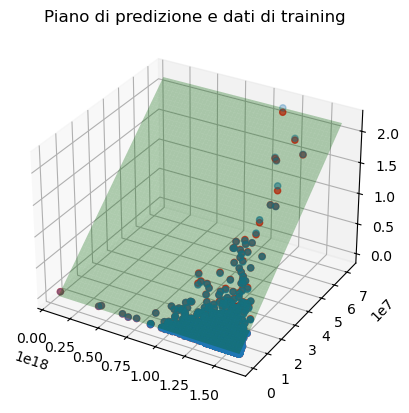

In [ ]:
xy = daTed[['date', 'views']]
xy["date"] = xy["date"].values.astype(float)
z  = daTed["likes"]

xy_train, xy_valid, z_train, z_valid = train_test_split(xy, z, test_size=0.2, random_state=1)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)


z_pred_train = create_3d_plot(xy_train, z_train, "date", "views", lin_reg, plt)
# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_


Score: 0.9992605601358914


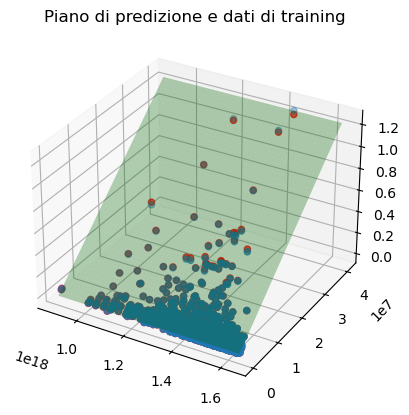

In [ ]:
# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_

z_pred_valid = create_3d_plot(xy_valid, z_valid, "date", "views", lin_reg, plt)

In [ ]:
print ('MAE:',  metrics.mean_absolute_error(z_valid, z_pred_valid))
print ('MSE:',  metrics.mean_squared_error(z_valid, z_pred_valid))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(z_valid, z_pred_valid)))

MAE: 1152.287179466049
MSE: 8034853.998544703
RMSE: 2834.5818031139447


### Versione con il modello nullo

In [ ]:
# Idea: osservo se il mio modello di predizione è più efficace (errore più basso) 
# di un modello nullo in cui si tira a caso sempre la media

#calcolate lo score medio
mean_likes = xy_valid['views'].mean()

# create la nuova x con lo stesso numero di campioni del validation set originale, 
# e con tutti i valori uguali al valore medio dello score appena calcolato
null_model_y = [mean_likes] * xy_valid['views'].shape[0]

#stampate gli errori
print ('MAE:', metrics.mean_absolute_error(xy_valid['views'], null_model_y))
print ('MSE:', metrics.mean_squared_error(xy_valid['views'], null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(xy_valid['views'], null_model_y)))

MAE: 1745883.0642689634
MSE: 11808525886038.516
RMSE: 3436353.574072161


Da questi risultati possiamo vedere come tutte le seguenti misure: MAE (errore medio assoluto), MSE (errore quadratico medio) e RMSE (radice dell'errore quadratico medio) del modello nullo siano di gran nulli magggiori rispetto a quello in cui si tira a caso la media.<br>
Ciò significa che il nostro modello di predizione ottenuto è più efficace rispetto ad un modello in cui non esiste un metodo di predizione vero e proprio ma si tira solamente a caso prendendo solo in considerazione la media.

### TEST REGRESSION VIEWS, LIKES -> DATA

Score: 0.011730292928266994


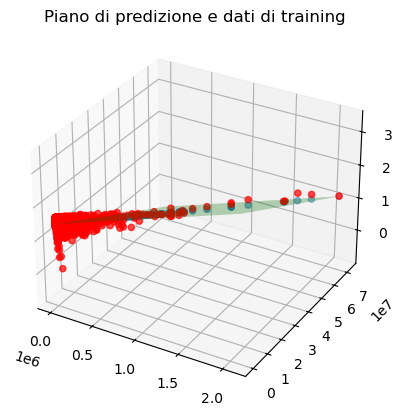

In [ ]:
# DA FARE
# Forse predirre qualcosa di più complesso? 
# (siccome, data la correlazione fra like e views, viene un 
#  modello molto buono)

xy_train, xy_valid, z_train, z_valid = train_test_split(daTed[['likes', 'views']], daTed['date'], test_size=0.2, random_state=1)

# tradotto in numeri per poter fare la regressione
z_train = z_train.values.astype(float)
z_valid = z_valid.values.astype(float)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)


z_pred_train = create_3d_plot(xy_train, z_train, "likes", "views", lin_reg, plt)


# segue z = ax + by + c
# z_hat = x_train * lin_reg.coef_[0] + y_train * lin_reg.coef_[1] + lin_reg.intercept_

# 5. Clustering (normalizzazione)

#### Nomalizzazione dei dati

In [ ]:
daTed['date_int'] = daTed['date'].astype(int)

#arr_sil = [(cluster_df(daTed, 'date', 'views', 'likes', 4)) for k in range(2,10)]
cluster_df(daTed, 'date_int', 'views', 'likes', 4)

# fig = plt.figure()
# plt.bar(range(2, 10), arr_sil)
# plt.show()


In [ ]:

# daTed3 = daTed

# theme_list  = ["climate", "COVID", "health", "war", "AI", "like ", "love", "brain", "life", "science", "culture", "data", "music", "like" ]
# for x in range(len(theme_list)):
#     daTed3.loc[daTed3['title'].str.contains(theme_list[x]), 'tag_name'] = theme_list[x]

# daTed3 = daTed3.loc[daTed3.tag_name.notna()]

# xy_train, xy_valid, z_train, z_valid = train_test_split(daTed3[['tag_name', 'likes']], daTed3[['views']], test_size=0.2, random_state=1)


# regressor = LinearRegression()
# lin_reg = regressor.fit(xy_train, z_train)


# z_pred_train = create_3d_plot(xy_train, z_train, "date", "views", lin_reg, plt)


Score: 0.39654502585756835


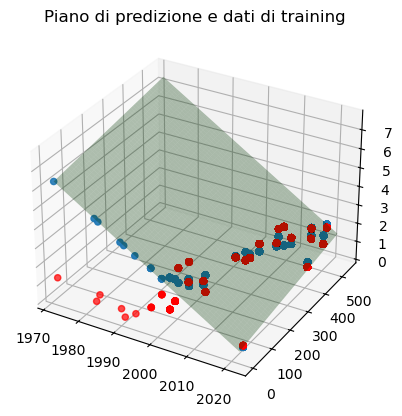

In [101]:
xy_train, xy_valid, z_train, z_valid = train_test_split(daTed[['date_year', 'count_year']], daTed['mean_views_year'], test_size=0.2, random_state=1)

z_train = z_train.values
z_valid = z_valid.values

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)


z_pred_train = create_3d_plot(xy_train, z_train, "date_year", "count_year", lin_reg, plt)
# z_pred_valid = create_3d_plot(xy_valid, z_valid, "date_year", "count_year", lin_reg, plt)

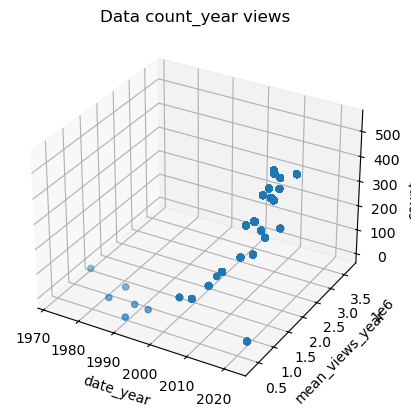

0.5650105332313741

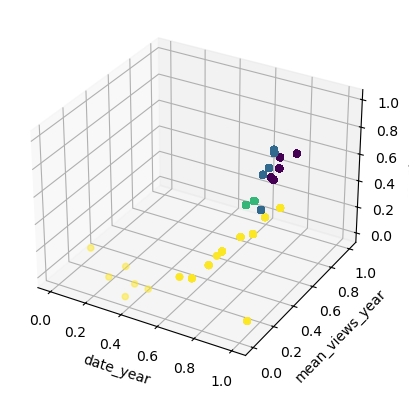

In [102]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(daTed["date_year"], daTed["mean_views_year"], daTed["count_year"])
ax.set_xlabel("date_year")
ax.set_ylabel("mean_views_year")
ax.set_zlabel("count_year")
ax.set_title('Data count_year views')
# create_3d_plot_gif(ax, fig)
plt.show()

cluster_df(daTed, 'date_year', 'mean_views_year', 'count_year', 4)
